In [166]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nussl
from utils import viz, data
import yaml
import os

In [207]:
import json
from nussl.datasets import transforms as nussl_tfm
from pathlib import Path

In [208]:
from models.MaskInference import MaskInference
from models.UNet import UNetSpect
nussl.ml.register_module(MaskInference)
nussl.ml.register_module(UNetSpect)

In [209]:
os.listdir('models/')

['.ipynb_checkpoints',
 'test_auto',
 '__pycache__',
 'MaskInference.py',
 'Waveform.py',
 'UNet.py',
 'ST_unet_8f',
 'Filterbank.py',
 'ST_mask_1layer',
 'ST_mask_15layer',
 'ST_mask_5layer',
 'ST_mask_10layer',
 'ST_mask_256hidden',
 'ST_unet_32f',
 'Clustering.py',
 'ST_mask_10layer_L2',
 'ST_mask_32hidden',
 'ST_unet_16f']

In [236]:
model_name = 'ST_mask_15layer'

In [237]:
model_path = 'models/'+model_name+'/checkpoints/latest.model.pth'
config_path = 'models/'+model_name+'/configs.yml'
#Optimizer checkpoints no longer stored
#optimizer_path = 'models/'+model_name+'/checkpoints/latest.optimizer.pth'

In [238]:
#Load yaml configs into configs dictionary
with open(config_path,'r') as f:
    configs = yaml.safe_load(f)
    f.close()
stft_params = nussl.STFTParams(**configs['stft_params'])

In [239]:
model_checkpoint = torch.load(model_path,map_location=torch.device('cpu'))
#Optimizer checkpoints no longer stored
#optimizer_checkpoint = torch.load(optimizer_path,map_location=torch.device('cpu'))

In [240]:
model_checkpoint['metadata']['trainer.state_dict']

{'epoch': 25,
 'epoch_length': 25,
 'max_epochs': 25,
 'output': {'loss': 0.00041419488843530416},
 'metrics': {'avg_loss': 0.0005392451635786389},
 'seed': None}

In [241]:
val_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['validation/loss']
train_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['train/loss']
n_epochs = model_checkpoint['metadata']['trainer.state_dict']['epoch']

Text(0.5, 0, 'Epoch')

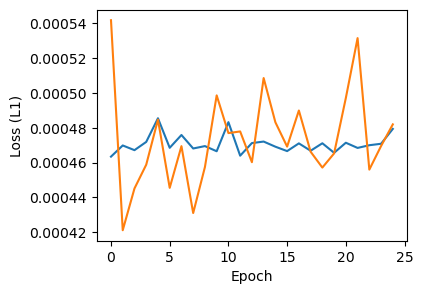

In [242]:
x = np.arange(n_epochs)
plt.figure(figsize=(4,3))
plt.plot(x,val_loss)
plt.plot(x,train_loss)
plt.ylabel('Loss (L1)')
plt.xlabel('Epoch')

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


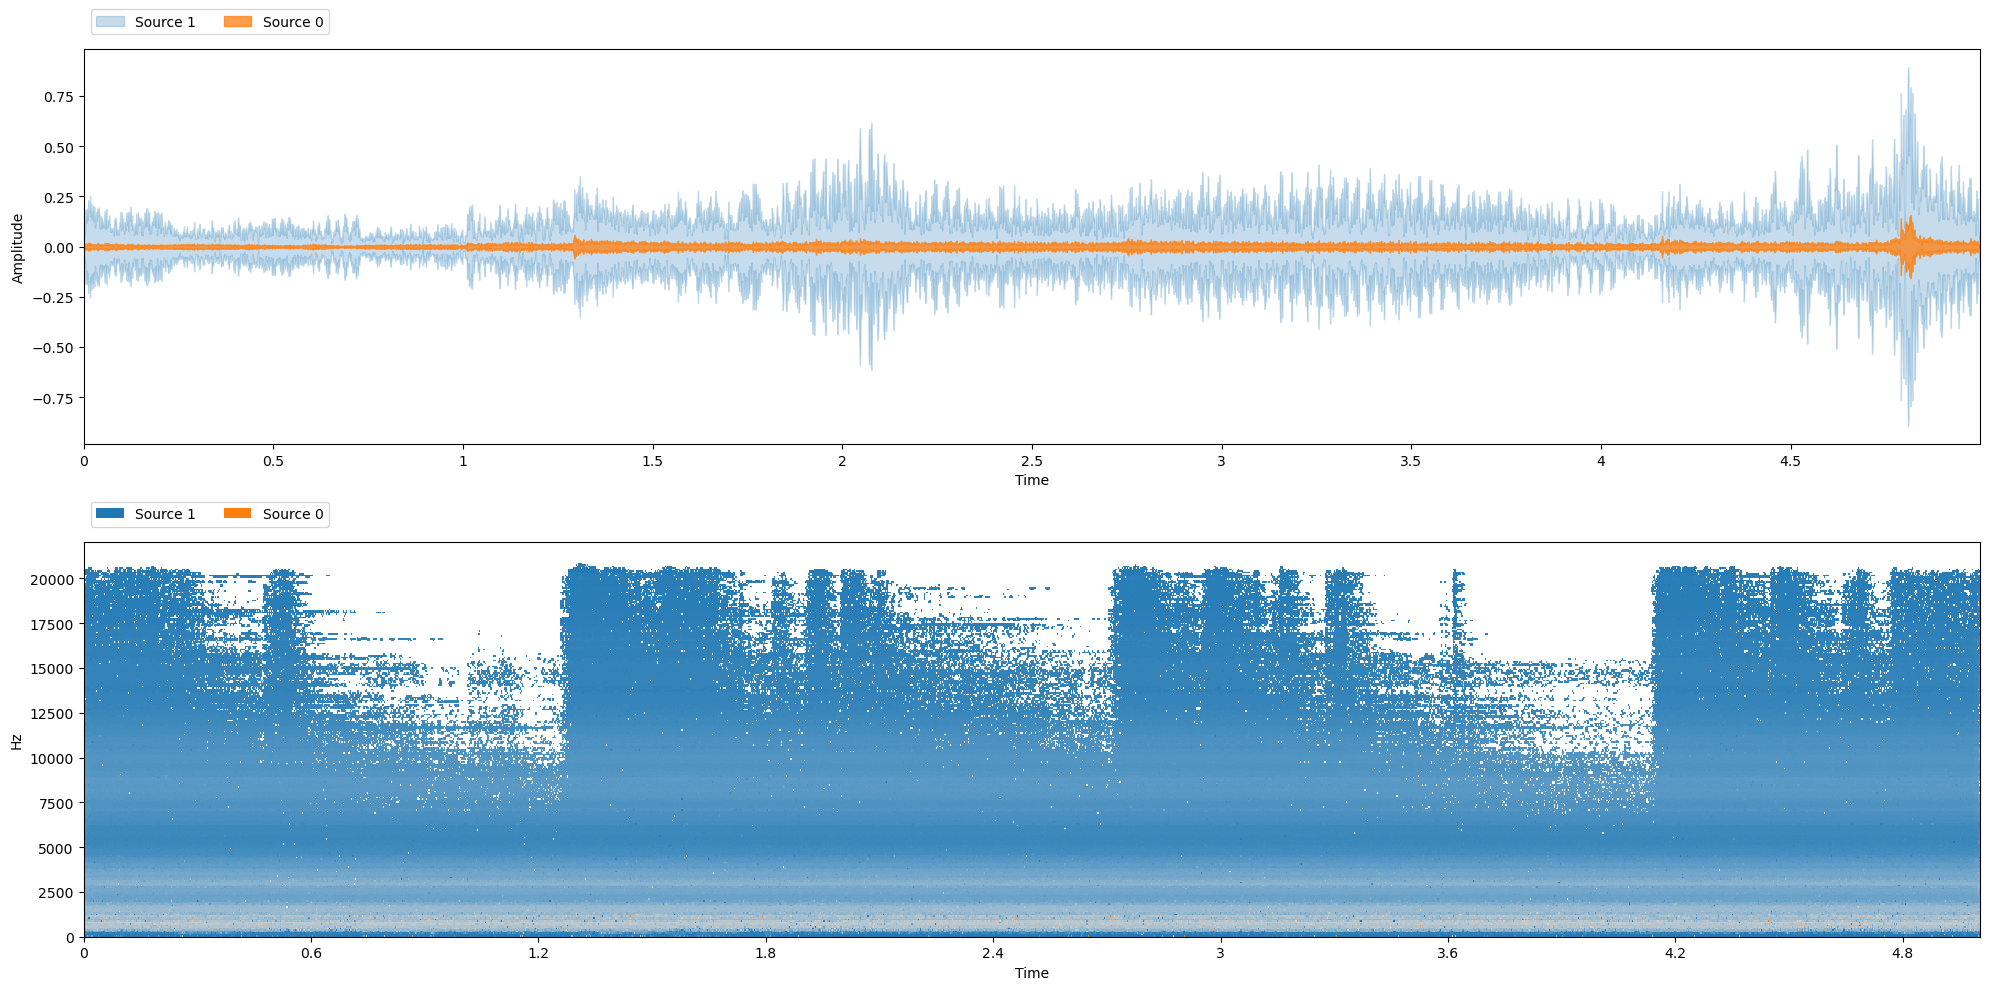


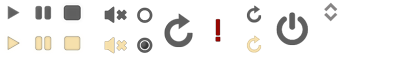
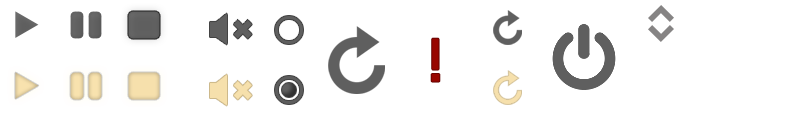
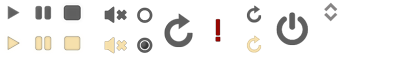

In [243]:
#Load in the model
separator = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path=model_path,
    device='cpu',
)

#Test on the data
test_folder = configs['test_folder']
tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
])
test_data = data.mixer(stft_params, transform=tfm, fg_path=configs['test_folder'], num_mixtures=50, coherent_prob=1.0, duration=5)

item = test_data[5]
separator.audio_signal = item['mix']
estimates = separator()
estimates.append(item['mix'] - estimates[0])

viz.show_sources(estimates)

In [244]:
item

{'mix': <nussl.core.audio_signal.AudioSignal at 0x7f7aec21a920>,
 'sources': {'vocals': <nussl.core.audio_signal.AudioSignal at 0x7f7b04416830>,
  'bass+drums+other': <nussl.core.audio_signal.AudioSignal at 0x7f7b04415420>},
 'metadata': {'jam': <JAMS(file_metadata=<FileMetadata(...)>,
        annotations=[1 annotation],
        sandbox=<Sandbox(...)>)>,
  'idx': 5},
 'index': 5}